In [1]:
import pickle
import os

from datetime import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

import xgboost as xgb

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler



In [2]:
df = pd.read_csv('../../data/Top100_prediction_con.csv')
print(df.shape)
df.sample(1)

(1739323, 12)


,Unnamed: 0,id,store,date,sales,item,store_code,yearweek,sell_price,weekday,event,income
354847,14491618,SUPERMARKET_3_546_NYC_3,Tribeca,2012-05-18,6,SUPERMARKET_3_546,NYC_3,201220,7.176,Friday,0.0,43.056


In [4]:
df = df[(df['store_code']=='BOS_1')&(df['item']=='SUPERMARKET_3_586')]

In [3]:
ts_predict = df[['date','sales','weekday','event']]

In [5]:
ts_predict

,date,sales,weekday,event
0,2011-01-29,4,Saturday,0.0
1,2011-01-29,4,Saturday,0.0
2,2011-01-29,0,Saturday,0.0
3,2011-01-29,4,Saturday,0.0
4,2011-01-29,0,Saturday,0.0
...,...,...,...,...
1739318,2016-04-24,0,Sunday,0.0
1739319,2016-04-24,16,Sunday,0.0
1739320,2016-04-24,2,Sunday,0.0
1739321,2016-04-24,0,Sunday,0.0


In [7]:
ts_predict = pd.get_dummies(data=ts_predict, columns=['weekday'], dtype=int)

In [8]:
ts_predict['date'] = pd.to_datetime(ts_predict['date'])

In [9]:
ts_predict.sort_values('date', ascending=True, inplace=True)

In [10]:
ts_predict.set_index('date', inplace=True)

In [75]:
ts_predict.tail(1)

,sales,event,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
date,,,,,,,,,
2016-04-24,58,0.0,0,0,0,1,0,0,0


In [11]:
ts_predict1 = ts_predict.copy()

In [12]:
ts_predict1 = ts_predict[['sales']]
ts_predict1.head(1)

,sales
date,
2011-01-29,4


In [13]:
ts_predict1 = ts_predict1.asfreq('D')

ValueError: cannot reindex on an axis with duplicate labels

Train dates : 2011-01-29 00:00:00 --- 2016-04-24 00:00:00  (n=1739293)
Test dates  : 2016-04-24 00:00:00 --- 2016-04-24 00:00:00  (n=30)


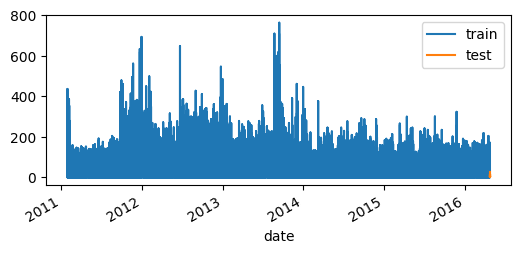

In [16]:
steps = 30
data_train = ts_predict1[:-steps]
data_test  = ts_predict1[-steps:]
print(
    f"Train dates : {data_train.index.min()} --- "
    f"{data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- "
    f"{data_test.index.max()}  (n={len(data_test)})"
)

fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['sales'].plot(ax=ax, label='train')
data_test['sales'].plot(ax=ax, label='test')
ax.legend();

In [17]:
import skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster
import shap

## Sin Hiperparámetros

In [18]:
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 14
             )
forecaster.fit(y=data_train['sales'])

/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/skforecast/utils/utils.py:1125: UserWarning: Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


In [90]:
predictions = forecaster.predict(steps=30)
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['sales'],
                y_pred = predictions
            )
print(f"Test error (MSE): {error_mse}")

Test error (MSE): 275.40478333333334


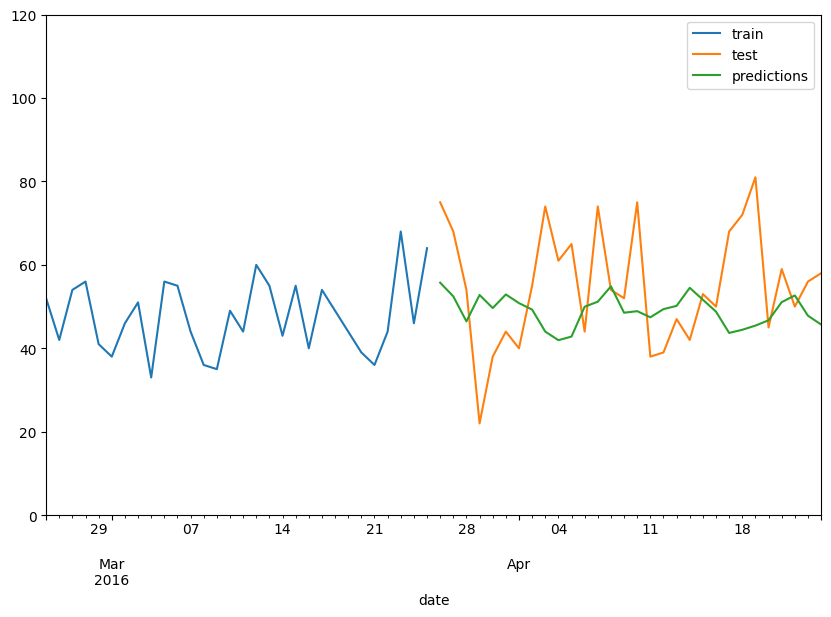

In [91]:
fig, ax = plt.subplots(figsize=(10, 6.5))
data_train['sales'][-30:].plot(ax=ax, label='train')
data_test['sales'][-30:].plot(ax=ax, label='test')
ax.set_ylim(0,120)
predictions.plot(ax=ax, label='predictions')
ax.legend();

## CON HIPERPARÁMETROS

In [49]:
# Hyperparameters: grid search
# ==============================================================================
steps = 30
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 7 # This value will be replaced in the grid search
             )

# Candidate values for lags
lags_grid = [3,4,5,7,8,10, 14, 20]

# Candidate values for regressor's hyperparameters
param_grid = {
    'n_estimators': [100, 250],
    'max_depth': [3, 8]
}

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data_train['sales'],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = steps,
                   metric             = 'mean_squared_error',
                   initial_train_size = int(len(data_train)*0.5),
                   fixed_train_size   = False,
                   refit              = False,
                   skip_folds         = None,
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = False
               )

Number of models compared: 32.


lags grid: 100%|██████████| 8/8 [05:21<00:00, 40.24s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 8, 'n_estimators': 100}
  Backtesting metric: 1329.8642308184685



/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [100]:
regressor = RandomForestRegressor(n_estimators=100, max_depth=8, random_state=123)
forecaster = ForecasterAutoreg(
                 regressor = regressor,
                 lags      = 12
             )
forecaster.fit(y=data_train['sales'])

In [101]:
predictions = forecaster.predict(steps=30)
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['sales'],
                y_pred = predictions
            )
print(f"Test error (MSE): {error_mse}")

Test error (MSE): 238.7978958896629


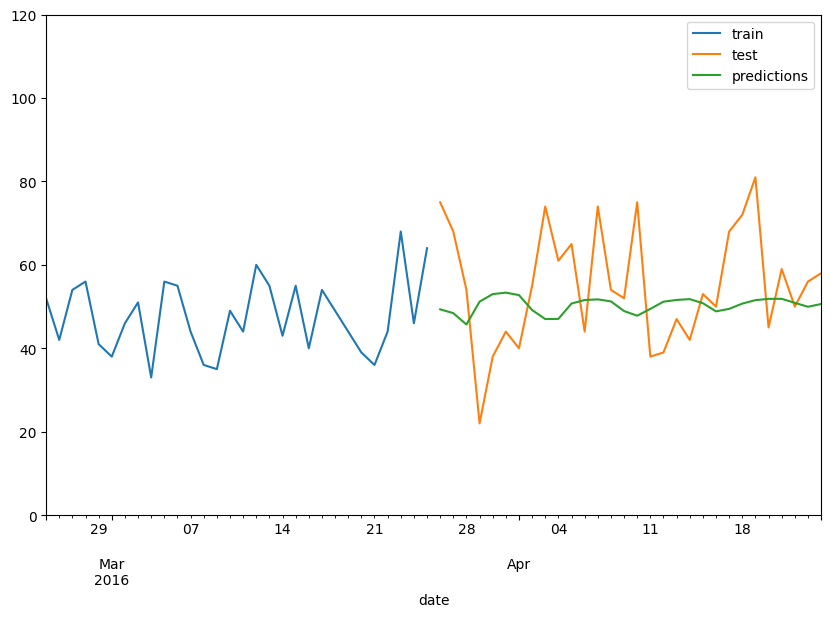

In [102]:
fig, ax = plt.subplots(figsize=(10, 6.5))
data_train['sales'][-30:].plot(ax=ax, label='train')
data_test['sales'][-30:].plot(ax=ax, label='test')
ax.set_ylim(0,120)
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [24]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['sales'],
                y_pred = predictions
            )
print(f"Test error (MSE): {error_mse}")

Test error (MSE): 202.32829983421115


## Con exógenas

In [104]:
data_test = ts_predict.copy()

In [105]:
ts_predict.head(1)

,sales,event,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
date,,,,,,,,,
2011-01-29,53,0.0,0,0,1,0,0,0,0


In [106]:
ts_predict.sort_values('date', ascending=True)
ts_predict.head(1)

,sales,event,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
date,,,,,,,,,
2011-01-29,53,0.0,0,0,1,0,0,0,0


In [28]:
# # Definir el punto de división (80% de los datos para entrenamiento)
# train_size = -30

# # Dividir la serie objetivo en train y test
# y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# # Dividir las variables exógenas en train y test
# exog_train, exog_test = exog.iloc[:train_size], exog.iloc[train_size:]

In [107]:
y = ts_predict['sales']
y = y.asfreq('D')

In [108]:
exog = ts_predict[['event', 'weekday_Friday', 'weekday_Monday','weekday_Saturday', 'weekday_Sunday','weekday_Thursday','weekday_Tuesday','weekday_Wednesday']]
exog = exog.asfreq('D')

In [109]:
y_train, y_test= y[:-30], y[-30:]
exog_train, exog_test = exog[:-30], exog[-30:]

In [119]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor

# Crear el forecaster con el modelo que quieras (ej. RandomForest)
forecaster = ForecasterAutoreg(
    regressor=RandomForestRegressor(),
    lags=12 # Usamos 7 días de rezago, ajusta según sea necesario
)

# Entrenar el forecaster usando los datos de entrenamiento y variables exógenas
forecaster.fit(y=y_train, exog=exog_train)

In [120]:
# Hacer predicciones para el tamaño del conjunto de prueba
steps = len(y_test)  # Número de pasos igual al tamaño de y_test
predictions = forecaster.predict(steps=steps, exog=exog_test)

# Evaluar el modelo comparando las predicciones con los valores reales
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 174.59628333333333


In [103]:
import joblib

In [121]:
joblib.dump(forecaster, 'modelo_forecast.pkl')

['modelo_forecast.pkl']

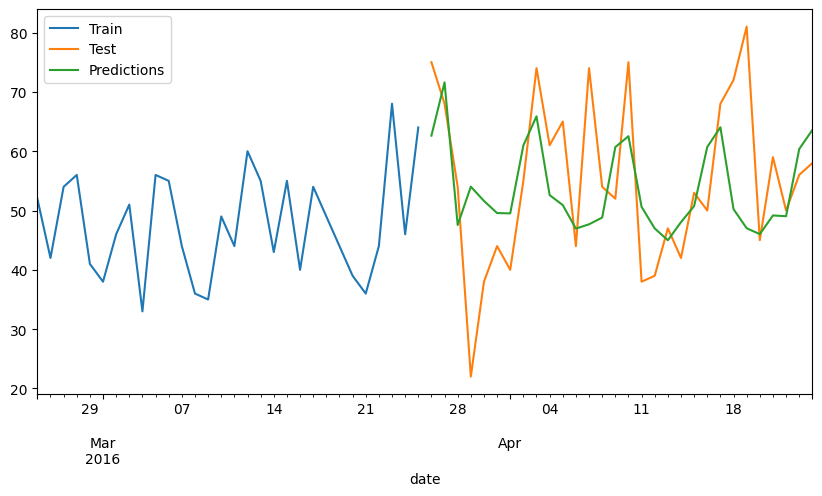

In [63]:
fig, ax = plt.subplots(figsize=(10, 5))
y_train[-30:].plot(ax=ax, label='Train')
y_test[-30:].plot(ax=ax, label='Test')
predictions.plot(ax=ax, label='Predictions')
ax.legend()
plt.show()

### CON HIPERPARAMETROS - EXOGENA

In [ ]:
# Definir el modelo con un regressor base
forecaster = ForecasterAutoreg(
    regressor=RandomForestRegressor(random_state=42),
    lags=5  # Esta es solo una configuración inicial, la ajustaremos con GridSearch
)

# Parámetros del RandomForest y los lags a buscar
param_grid = {
    'n_estimators': [50, 100, 200],  # Número de árboles en el bosque
    'max_depth': [None, 5, 10],  # Profundidad máxima de los árboles
    'min_samples_split': [2, 5],  # Muestras mínimas para dividir un nodo
    'min_samples_leaf': [1, 2],  # Muestras mínimas en una hoja
}

lags_grid = [7, 14, 21, 30]

# Realizar el GridSearch
results_grid = grid_search_forecaster(
    forecaster=forecaster,
    y=y_train,  # Serie temporal de entrenamiento
    exog=exog_train,  # Variables exógenas si tienes alguna
    param_grid=param_grid,  # La cuadrícula de parámetros
    lags_grid=lags_grid,
    steps=7,  # Cuántos pasos (días) predecir hacia adelante
    metric='mean_squared_error',  # Métrica de evaluación (también puede ser MAE, etc.)
    initial_train_size=len(y_train) - 30,  # Tamaño inicial de la ventana de entrenamiento
    refit=True,  # Reentrenar el modelo en cada combinación de hiperparámetros
    return_best=True,  # Devolver el mejor modelo
    verbose=True
)

# Mostrar los mejores parámetros y el error
print(f"Mejores parámetros: {results_grid}")
print(f"Mejor RMSE: {results_grid['mean_squared_error'].min()}")


In [58]:
# Crear el forecaster con el modelo que quieras (ej. RandomForest)
forecaster = ForecasterAutoreg(
    regressor=RandomForestRegressor(max_depth=None, min_samples_leaf=5,min_samples_split=10, n_estimators=100),
    lags=12 # Usamos 7 días de rezago, ajusta según sea necesario
)

# Entrenar el forecaster usando los datos de entrenamiento y variables exógenas
forecaster.fit(y=y_train, exog=exog_train)
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(min_samples_leaf=5, min_samples_split=10) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Transformer for y: None 
Transformer for exog: None 
Window size: 12 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Exogenous variables names: ['event', 'weekday_Friday', 'weekday_Monday', 'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday', 'weekday_Tuesday', 'weekday_Wednesday'] 
Training range: [Timestamp('2011-01-29 00:00:00'), Timestamp('2016-03-25 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state

In [59]:
# Hacer predicciones para el tamaño del conjunto de prueba
steps = len(y_test)  # Número de pasos igual al tamaño de y_test
predictions = forecaster.predict(steps=steps, exog=exog_test)

mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 169.64756734296242


In [ ]:
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100

print(f'El error MAPE es: {mape:.2f}%')

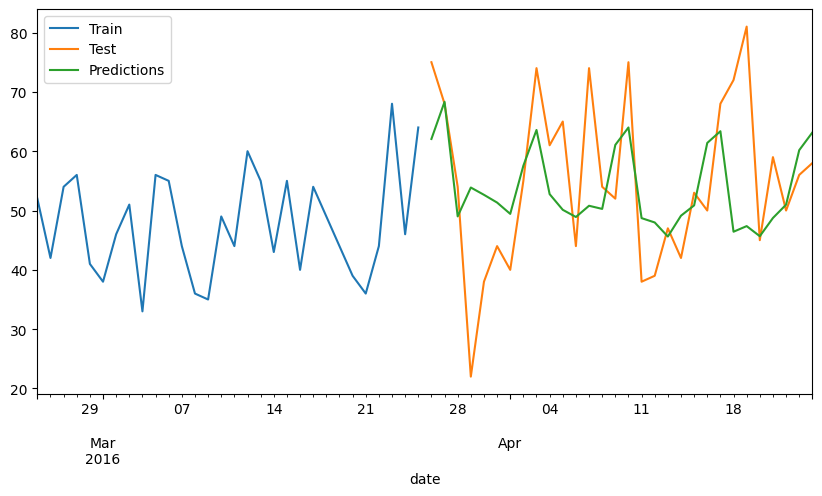

In [60]:
fig, ax = plt.subplots(figsize=(10, 5))
y_train[-30:].plot(ax=ax, label='Train')
y_test[-30:].plot(ax=ax, label='Test')
predictions.plot(ax=ax, label='Predictions')
ax.legend()
plt.show()